In [1]:
!wget http://www.cs.cmu.edu/~enron/enron_mail_20110402.tgz -O /content/enron_mail_20110402.tgz
!tar -xzf /content/enron_mail_20110402.tgz -C /content/
!ls /content/enron_mail_20110402/maildir | head


--2025-09-13 16:55:08--  http://www.cs.cmu.edu/~enron/enron_mail_20110402.tgz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://download.srv.cs.cmu.edu/~enron/enron_mail_20110402.tgz [following]
--2025-09-13 16:55:10--  http://download.srv.cs.cmu.edu/~enron/enron_mail_20110402.tgz
Resolving download.srv.cs.cmu.edu (download.srv.cs.cmu.edu)... 128.2.172.95
Connecting to download.srv.cs.cmu.edu (download.srv.cs.cmu.edu)|128.2.172.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443469519 (423M) [application/x-gzip]
Saving to: ‘/content/enron_mail_20110402.tgz’

/content/enron_mail 100%[===================>] 422.92M  8.57MB/s    in 51s     

2025-09-13 16:56:02 (8.24 MB/s) - ‘/content/enron_mail_20110402.tgz’ saved [443469519/443469519]

allen-p
arnold-j
arora-h
badeer-r
bailey-s
bass-e
baughman-d
beck-

In [2]:
# run in a Colab cell
!pip install -q transformers sentence-transformers rouge-score python-dateutil pandas


**Cell 1 — Collect email file paths (change MAX_EMAILS to control how many files you parse)**

In [3]:
import os, re
ROOT = "/content/enron_mail_20110402/maildir"
MAX_EMAILS = 50000   # start small (2000). Increase to 10000+ if Colab can handle it.

def collect_email_files(root, max_files=2000):
    pattern = re.compile(r'^\d+\.?$')  # filenames like '381.' or '1234'
    files_list = []
    for dirpath, _, files in os.walk(root):
        for f in files:
            if pattern.match(f) or f.lower().endswith('.txt'):
                files_list.append(os.path.join(dirpath, f))
                if len(files_list) >= max_files:
                    return files_list
    return files_list

email_files = collect_email_files(ROOT, MAX_EMAILS)
print("Collected:", len(email_files), "files")
print("Sample:", email_files[:5])


Collected: 50000 files
Sample: ['/content/enron_mail_20110402/maildir/whalley-g/mariner/2.', '/content/enron_mail_20110402/maildir/whalley-g/mariner/1.', '/content/enron_mail_20110402/maildir/whalley-g/mariner/3.', '/content/enron_mail_20110402/maildir/whalley-g/mariner/4.', '/content/enron_mail_20110402/maildir/whalley-g/mariner/5.']


**Cell 2 — Robust parser that extracts headers & plain-text body (handles multipart)**

In [4]:
from email import policy
from email.parser import Parser
from dateutil import parser as dateparser
import pandas as pd
import traceback

def parse_date_safe(datestr):
    try:
        if datestr is None:
            return None
        return dateparser.parse(datestr, fuzzy=True)
    except Exception:
        return None

def get_body_from_msg(msg):
    """Return concatenated text/plain parts, fallback to payload string."""
    try:
        if msg.is_multipart():
            parts = []
            for part in msg.walk():
                ctype = part.get_content_type()
                cdisp = str(part.get('Content-Disposition') or "")
                if ctype == 'text/plain' and 'attachment' not in cdisp.lower():
                    payload = part.get_payload(decode=True)
                    if payload is None:
                        text = part.get_payload()
                    else:
                        charset = part.get_content_charset() or 'latin1'
                        text = payload.decode(charset, errors='replace')
                    parts.append(text)
            return "\n".join(parts).strip()
        else:
            payload = msg.get_payload(decode=True)
            if payload:
                charset = msg.get_content_charset() or 'latin1'
                return payload.decode(charset, errors='replace')
            else:
                return str(msg.get_payload())
    except Exception:
        return ""

def parse_email_file(path):
    try:
        with open(path, 'r', encoding='latin1', errors='replace') as f:
            raw = f.read()
        msg = Parser(policy=policy.default).parsestr(raw)
        body = get_body_from_msg(msg)
        return {
            "file_path": path,
            "message_id": msg.get("Message-ID"),
            "date_raw": msg.get("Date"),
            "date_parsed": parse_date_safe(msg.get("Date")),
            "from": msg.get("From"),
            "to": msg.get("To"),
            "subject": msg.get("Subject"),
            "body": body
        }
    except Exception as e:
        return {"file_path": path, "error": str(e), "trace": traceback.format_exc()}

# Parse all collected files
parsed = []
for i, fp in enumerate(email_files):
    parsed.append(parse_email_file(fp))
    if (i+1) % 200 == 0:
        print("Parsed:", i+1)

df = pd.DataFrame(parsed)
print("Parsed DataFrame shape:", df.shape)
display(df.head())

# Save intermediate CSV
DF_SAVE = "/content/enron_parsed_sample.csv"
df.to_csv(DF_SAVE, index=False)
print("Saved parsed CSV to", DF_SAVE)


Parsed: 200
Parsed: 400
Parsed: 600
Parsed: 800
Parsed: 1000
Parsed: 1200
Parsed: 1400
Parsed: 1600
Parsed: 1800
Parsed: 2000
Parsed: 2200
Parsed: 2400
Parsed: 2600
Parsed: 2800
Parsed: 3000
Parsed: 3200
Parsed: 3400
Parsed: 3600
Parsed: 3800
Parsed: 4000
Parsed: 4200
Parsed: 4400
Parsed: 4600
Parsed: 4800
Parsed: 5000
Parsed: 5200
Parsed: 5400
Parsed: 5600
Parsed: 5800
Parsed: 6000
Parsed: 6200
Parsed: 6400
Parsed: 6600
Parsed: 6800
Parsed: 7000
Parsed: 7200
Parsed: 7400
Parsed: 7600
Parsed: 7800
Parsed: 8000
Parsed: 8200
Parsed: 8400
Parsed: 8600
Parsed: 8800
Parsed: 9000
Parsed: 9200
Parsed: 9400
Parsed: 9600
Parsed: 9800
Parsed: 10000
Parsed: 10200
Parsed: 10400
Parsed: 10600
Parsed: 10800
Parsed: 11000
Parsed: 11200
Parsed: 11400
Parsed: 11600
Parsed: 11800
Parsed: 12000
Parsed: 12200
Parsed: 12400
Parsed: 12600
Parsed: 12800
Parsed: 13000
Parsed: 13200
Parsed: 13400
Parsed: 13600
Parsed: 13800
Parsed: 14000
Parsed: 14200
Parsed: 14400
Parsed: 14600
Parsed: 14800
Parsed: 15000
Par

,file_path,message_id,date_raw,date_parsed,from,to,subject,body
0,/content/enron_mail_20110402/maildir/whalley-g...,<20903341.1075852350231.JavaMail.evans@thyme>,"Fri, 29 Jun 2001 14:40:06 -0700",2001-06-29 14:40:06-07:00,j..edison@enron.com,"rick.buy@enron.com, a..fox@enron.com, e..haedi...",FW: Mariner Management Meeting Minutes,"\n\n -----Original Message-----\nFrom: \t""Cagl..."
1,/content/enron_mail_20110402/maildir/whalley-g...,<5673174.1075852350203.JavaMail.evans@thyme>,"Fri, 27 Jul 2001 09:56:06 -0700",2001-07-27 09:56:06-07:00,j..edison@enron.com,"rick.buy@enron.com, a..fox@enron.com, e..haedi...",FW: Mariner Management Meeting Minutes,"\n\n -----Original Message-----\nFrom: \t""Cagl..."
2,/content/enron_mail_20110402/maildir/whalley-g...,<7561390.1075852350257.JavaMail.evans@thyme>,"Fri, 22 Jun 2001 12:12:58 -0700",2001-06-22 12:12:58-07:00,j..edison@enron.com,"rick.buy@enron.com, a..fox@enron.com, e..haedi...",FW: Mariner Management Meeting Minutes,"\n\n -----Original Message-----\nFrom: \t""Cagl..."
3,/content/enron_mail_20110402/maildir/whalley-g...,<13658309.1075852350287.JavaMail.evans@thyme>,"Mon, 18 Jun 2001 12:26:00 -0700",2001-06-18 12:26:00-07:00,deborah.edison@enron.com,"rick.buy@enron.com, craig.fox@enron.com, mark....",FW: Mariner Management Meeting Minutes,\n\n\n <<6-14-01.doc>> <<SUMMARY.xls>>\n\nDon...
4,/content/enron_mail_20110402/maildir/whalley-g...,<9339349.1075852350316.JavaMail.evans@thyme>,"Tue, 12 Jun 2001 13:08:00 -0700",2001-06-12 13:08:00-07:00,deborah.edison@enron.com,"rick.buy@enron.com, craig.fox@enron.com, mark....",FW: Mariner Management Meeting Minutes,"\n\n -----Original Message-----\nFrom: \t""Cagl..."


Saved parsed CSV to /content/enron_parsed_sample.csv


**Cell 3 — Clean / Normalize subject & body (strip quoted blocks, remove emails/URLs)**

In [5]:
import re

def clean_body(text):
    if not text:
        return ""
    # Remove quoted replies (common in emails)
    text = re.sub(r"(?m)^>.*$", "", text)
    # Remove forwarded message lines
    text = re.sub(r"-----Original Message-----", "", text, flags=re.IGNORECASE)
    # Remove repetitive email headers
    text = re.sub(r"(From:|To:|Sent:|Subject:).*", "", text)
    # Remove multiple blank lines
    text = re.sub(r"\n\s*\n", "\n", text)
    return text.strip()

df["clean_body"] = df["body"].apply(clean_body)
df["body_length"] = df["clean_body"].apply(lambda x: len(x.split()))

# Drop emails with empty/very short bodies
df_clean = df[df["body_length"] > 10].copy()

print("Before cleaning:", df.shape)
print("After cleaning:", df_clean.shape)
display(df_clean[["subject", "clean_body"]].head())


Before cleaning: (50000, 10)
After cleaning: (47008, 10)


,subject,clean_body
0,FW: Mariner Management Meeting Minutes,"Cc:\tMelendrez, Jesus\n <<6-28-01.doc>> <<SUM..."
1,FW: Mariner Management Meeting Minutes,"Cc:\tMelendrez, Jesus\n <<7-26-01.doc>> <<SUM..."
2,FW: Mariner Management Meeting Minutes,"Cc:\tMelendrez, Jesus\nDebbie:\nWould you plea..."
3,FW: Mariner Management Meeting Minutes,<<6-14-01.doc>> <<SUMMARY.xls>>\nDonna M. Cag...
4,FW: Mariner Management Meeting Minutes,"Cc:\tMelendrez, Jesus\n <<6-6-01.doc>> <<SUMM..."


**Cell 4: Summarize Cleaned Emails Using Transformer Model (BART)**

In [6]:
from transformers import pipeline

# Summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_email(text):
    if not text or len(text.split()) < 30:
        return text  # Skip very short emails
    try:
        summary = summarizer(
            text,
            max_length=60,
            min_length=20,
            do_sample=False
        )
        return summary[0]['summary_text']
    except Exception:
        return text

# Take only first 50 emails to test
sample_emails = df_clean.head(50).copy()
sample_emails["summary"] = sample_emails["clean_body"].apply(summarize_email)

display(sample_emails[["subject", "clean_body", "summary"]])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,subject,clean_body,summary
0,FW: Mariner Management Meeting Minutes,"Cc:\tMelendrez, Jesus\n <<6-28-01.doc>> <<SUM...",Donna M. Cagle is the President and CEO of Mar...
1,FW: Mariner Management Meeting Minutes,"Cc:\tMelendrez, Jesus\n <<7-26-01.doc>> <<SUM...",Donna M. Cagle is the Executive Administrator ...
2,FW: Mariner Management Meeting Minutes,"Cc:\tMelendrez, Jesus\nDebbie:\nWould you plea...",Donna M. Cagle is the President and CEO of Mar...
3,FW: Mariner Management Meeting Minutes,<<6-14-01.doc>> <<SUMMARY.xls>>\nDonna M. Cag...,Donna M. Cagle is the Executive Administrator ...
4,FW: Mariner Management Meeting Minutes,"Cc:\tMelendrez, Jesus\n <<6-6-01.doc>> <<SUMM...",Donna M. Cagle is the President and CEO of Mar...
5,RE: John Arnold Access to Crude,No problem\n----Original Message-----\n >\n ...,"At his request, John was set up this morning w..."
6,RE: UK P/L,What is the structured derivatives portfolio a...,The UK P/L has made a number of changes to its...
7,RE: 12/27 NXC1 EOL Trades with Valero,I do think that more of the trades will ultima...,The NXC1 trades done with Valero on 12/27 have...
8,Re: FW: Enron Everywhere,"don't know about the relationship with dave, ...",Portland General did just get a dash approved ...
9,"Re: Tuesday, June 12th Reports",how did my august position change? i didn't t...,how did my august position change? i didn't t...


**Cell 5: Perform Sentiment Analysis on Emails**

In [7]:
# 🔥 Cell 5: Perform Sentiment Analysis on Emails

from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

def get_sentiment(text):
    """Classify sentiment of text using Hugging Face sentiment pipeline."""
    try:
        if not text.strip():
            return "neutral"
        # Limit to first 512 characters for faster inference
        result = sentiment_analyzer(text[:512])[0]
        return result['label']
    except Exception:
        return "error"

# Apply sentiment analysis on sample emails
sample_emails["sentiment"] = sample_emails["clean_body"].apply(get_sentiment)

# Display results
display(sample_emails[["subject", "summary", "sentiment"]].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


,subject,summary,sentiment
0,FW: Mariner Management Meeting Minutes,Donna M. Cagle is the President and CEO of Mar...,NEGATIVE
1,FW: Mariner Management Meeting Minutes,Donna M. Cagle is the Executive Administrator ...,NEGATIVE
2,FW: Mariner Management Meeting Minutes,Donna M. Cagle is the President and CEO of Mar...,POSITIVE
3,FW: Mariner Management Meeting Minutes,Donna M. Cagle is the Executive Administrator ...,NEGATIVE
4,FW: Mariner Management Meeting Minutes,Donna M. Cagle is the President and CEO of Mar...,NEGATIVE


**Cell 6: Extract Keywords from Emails**

In [8]:
# 🔥 Cell 6: Extract Keywords from Emails

from collections import Counter
import re

def extract_keywords(text, top_n=5):
    """Extract top N keywords from a given text."""
    if not text:
        return []
    # Find all words
    words = re.findall(r'\b\w+\b', text.lower())
    # Basic stopwords list
    stopwords = set([
        "the","and","for","with","this","that","from","to","of","in","on",
        "at","is","a","i","you","we","it","as","be","are","was","by","an"
    ])
    # Remove stopwords & short words
    words = [w for w in words if w not in stopwords and len(w) > 3]
    # Get most common words
    common = Counter(words).most_common(top_n)
    return [w for w, _ in common]

# Apply keyword extraction
sample_emails["keywords"] = sample_emails["clean_body"].apply(lambda x: extract_keywords(x))

# Display emails with keywords
display(sample_emails[["subject", "keywords"]].head())


,subject,keywords
0,FW: Mariner Management Meeting Minutes,"[summary, mariner, energy, melendrez, jesus]"
1,FW: Mariner Management Meeting Minutes,"[summary, mariner, energy, melendrez, jesus]"
2,FW: Mariner Management Meeting Minutes,"[summary, mariner, energy, melendrez, jesus]"
3,FW: Mariner Management Meeting Minutes,"[summary, mariner, energy, donna, cagle]"
4,FW: Mariner Management Meeting Minutes,"[summary, mariner, energy, melendrez, jesus]"


**Cell 7: Visualize Sentiment Distribution and Top Keywords**


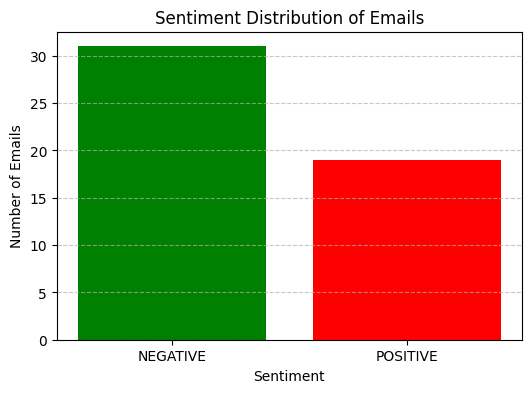

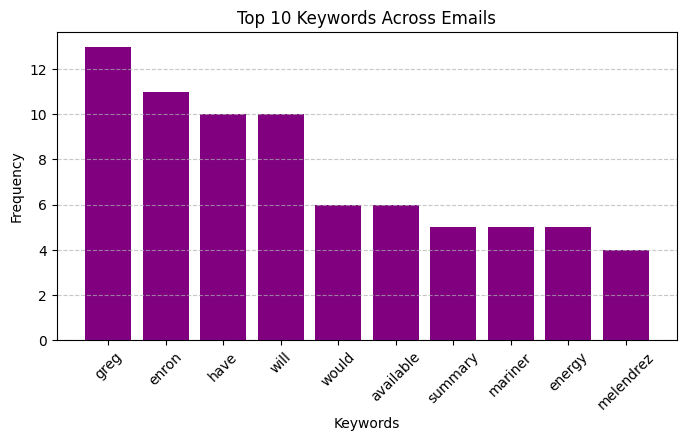

In [9]:
# 🔥 Cell 7: Visualize Sentiment Distribution and Top Keywords

import matplotlib.pyplot as plt
from collections import Counter

# --- Sentiment Distribution ---
sentiment_counts = sample_emails["sentiment"].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution of Emails")
plt.xlabel("Sentiment")
plt.ylabel("Number of Emails")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Top Keywords ---
# Flatten all keywords into one list
all_keywords = [kw for kws in sample_emails["keywords"] for kw in kws]
keyword_counts = Counter(all_keywords).most_common(10)

keywords, counts = zip(*keyword_counts)

plt.figure(figsize=(8, 4))
plt.bar(keywords, counts, color='purple')
plt.title("Top 10 Keywords Across Emails")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Cell 8: Additional Important Visualizations - Email Length & Top Senders**


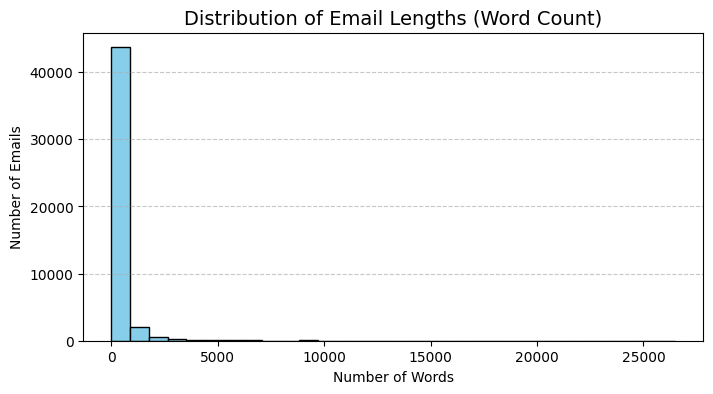

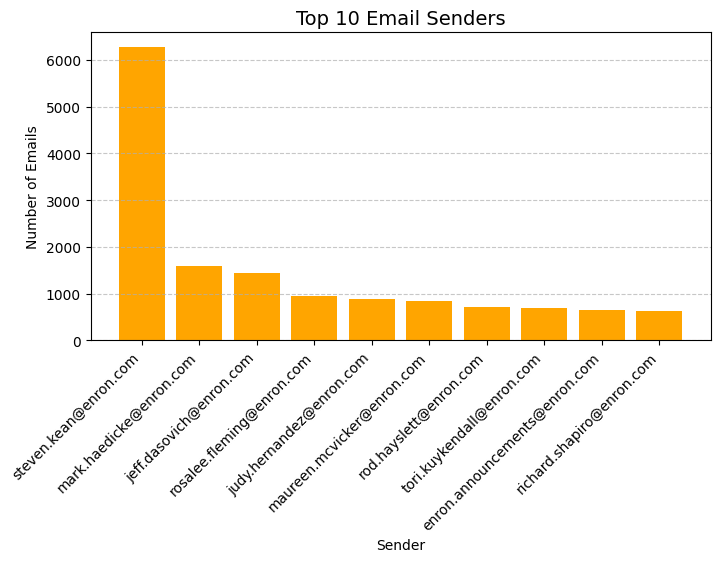

In [10]:
# 🔥 Cell 8: Additional Important Visualizations - Email Length & Top Senders

import matplotlib.pyplot as plt

# --- 1️⃣ Email Length Distribution ---
plt.figure(figsize=(8, 4))
plt.hist(df_clean["body_length"], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Email Lengths (Word Count)", fontsize=14)
plt.xlabel("Number of Words")
plt.ylabel("Number of Emails")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 2️⃣ Top Senders ---
top_senders = df_clean["from"].value_counts().head(10)

plt.figure(figsize=(8, 4))
plt.bar(top_senders.index, top_senders.values, color='orange')
plt.title("Top 10 Email Senders", fontsize=14)
plt.xlabel("Sender")
plt.ylabel("Number of Emails")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Classification of the importance and non important emails and also Comparison: Logistic Regression vs Decision Tree**

=== Logistic Regression Classification Report ===
               precision    recall  f1-score   support

    Important       0.95      0.91      0.93      4292
Non-Important       0.93      0.96      0.94      5110

     accuracy                           0.94      9402
    macro avg       0.94      0.93      0.94      9402
 weighted avg       0.94      0.94      0.94      9402


=== Decision Tree Classification Report ===
               precision    recall  f1-score   support

    Important       0.99      0.99      0.99      4292
Non-Important       0.99      0.99      0.99      5110

     accuracy                           0.99      9402
    macro avg       0.99      0.99      0.99      9402
 weighted avg       0.99      0.99      0.99      9402



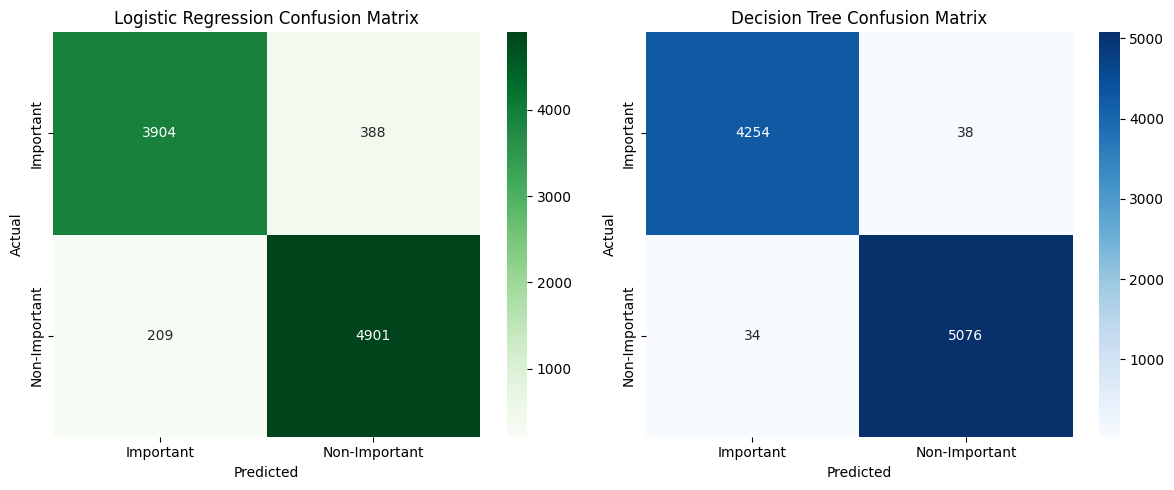

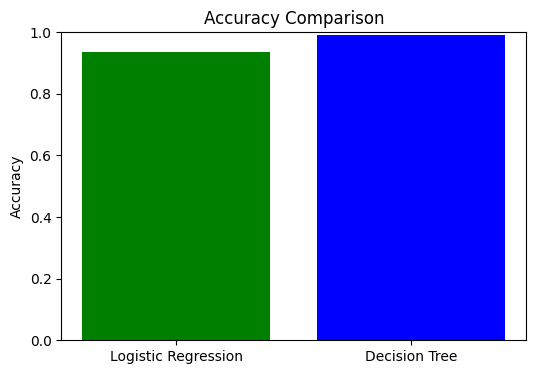

Logistic Regression Accuracy: 0.9365
Decision Tree Accuracy: 0.9923
Logistic Regression F1-score: 0.9290
Decision Tree F1-score: 0.9916


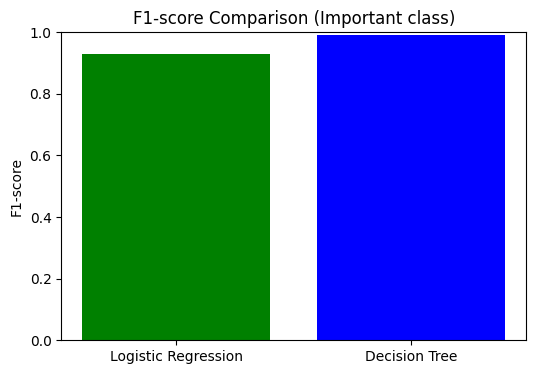

In [11]:
# 🔥 Classification Comparison: Logistic Regression vs Decision Tree
# classification of the important and non important
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Label Emails (Improved)
important_keywords = ['project','meeting','deadline','urgent','submit','report','team','important','reminder','task']

def label_email(text):
    text = text.lower()
    if any(word in text for word in important_keywords):
        return 'Important'
    else:
        return 'Non-Important'

df_clean['label'] = df_clean['clean_body'].apply(label_email)

# -----------------------------
# 2. Train-Test Split
X = df_clean['clean_body']
y = df_clean['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 3. TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# -----------------------------
# 4. Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# -----------------------------
# 5. Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_tfidf, y_train)
y_pred_dt = dt.predict(X_test_tfidf)

# -----------------------------
# 6. Classification Reports
print("=== Logistic Regression Classification Report ===")
print(classification_report(y_test, y_pred_lr))

print("\n=== Decision Tree Classification Report ===")
print(classification_report(y_test, y_pred_dt))

# -----------------------------
# 7. Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12,5))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Important','Non-Important'],
            yticklabels=['Important','Non-Important'], ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Important','Non-Important'],
            yticklabels=['Important','Non-Important'], ax=axes[1])
axes[1].set_title("Decision Tree Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# -----------------------------
# 8. Accuracy Comparison
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_dt = accuracy_score(y_test, y_pred_dt)

plt.figure(figsize=(6,4))
plt.bar(['Logistic Regression','Decision Tree'], [acc_lr, acc_dt], color=['green','blue'])

plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"Decision Tree Accuracy: {acc_dt:.4f}")

from sklearn.metrics import f1_score

# Compute F1 scores
f1_lr = f1_score(y_test, y_pred_lr, pos_label="Important")
f1_dt = f1_score(y_test, y_pred_dt, pos_label="Important")

# Print values
print(f"Logistic Regression F1-score: {f1_lr:.4f}")
print(f"Decision Tree F1-score: {f1_dt:.4f}")

# Plot bar chart for F1-scores
plt.figure(figsize=(6,4))
plt.bar(['Logistic Regression','Decision Tree'], [f1_lr, f1_dt], color=['green','blue'])
plt.title("F1-score Comparison (Important class)")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.show()



**6. Visualization: Class Distribution (Predicted vs Actual)**


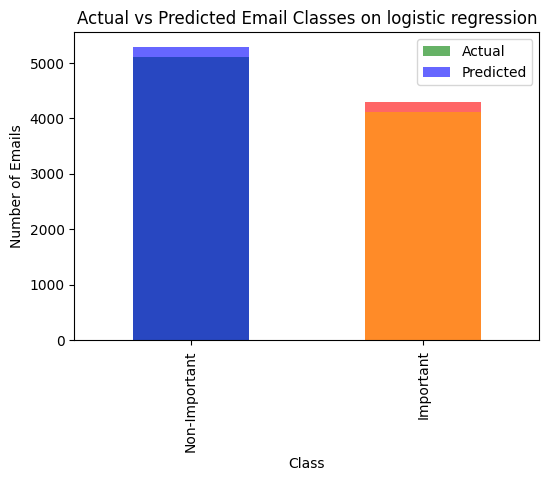

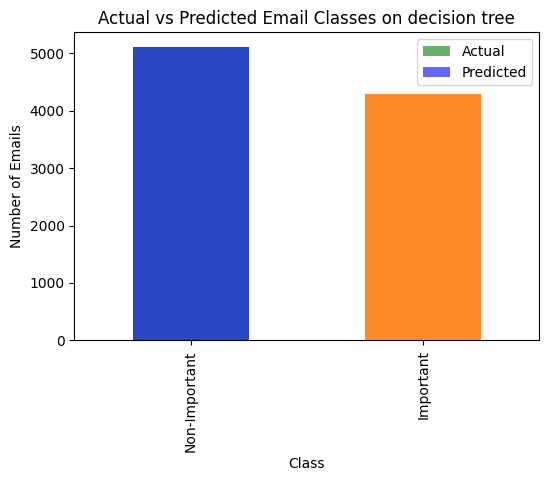

In [12]:


# -----------------------------
# 6. Visualization: Class Distribution (Predicted vs Actual)
plt.figure(figsize=(6,4))
y_test.value_counts().plot(kind='bar', color=['green','red'], alpha=0.6, label='Actual')
pd.Series(y_pred_lr).value_counts().plot(kind='bar', color=['blue','orange'], alpha=0.6, label='Predicted')
plt.title("Actual vs Predicted Email Classes on logistic regression")
plt.xlabel("Class")
plt.ylabel("Number of Emails")
plt.legend()
plt.show()


# -----------------------------
# 6. Visualization: Class Distribution (Predicted vs Actual)
plt.figure(figsize=(6,4))
y_test.value_counts().plot(kind='bar', color=['green','red'], alpha=0.6, label='Actual')
pd.Series(y_pred_dt).value_counts().plot(kind='bar', color=['blue','orange'], alpha=0.6, label='Predicted')
plt.title("Actual vs Predicted Email Classes on decision tree")
plt.xlabel("Class")
plt.ylabel("Number of Emails")
plt.legend()
plt.show()



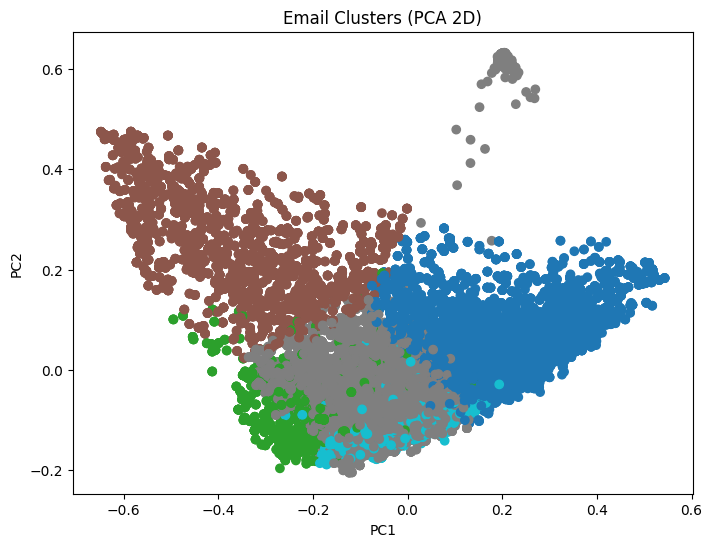

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Use TF-IDF vectors (already computed)
X_tfidf = tfidf.fit_transform(df_clean['clean_body'])

# Apply K-Means (you can try different n_clusters)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

df_clean['cluster'] = clusters

# Optional: visualize clusters in 2D using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10')
plt.title("Email Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
# Separate emails by classification
urgent_emails = df_clean[df_clean['label'] == 'Important']

# Group emails by cluster/topic
digest = {}
for cluster in sorted(df_clean['cluster'].unique()):
    cluster_emails = df_clean[df_clean['cluster'] == cluster]['clean_body'].tolist()
    digest[f"Topic {cluster}"] = cluster_emails[:5]  # Top 5 emails per cluster

# Optional: Print digest in a readable format
print("=== Daily Digest ===\n")
for category, emails in digest.items():
    print(f"{category}:")
    for email in emails:
        print(f"  - {email}")
    print()


=== Daily Digest ===

Topic 0:
  - What is the structured derivatives portfolio and what is in it?
----Original Message-----
   >
   >
   >Cc:          John Sherriff/LON/ECT@ECT
   >Bcc:      
   >Subj:      UK P/L
   >
   >
   >Greg,
   >See note below for detail but here is the exec summary.
   >
   >We had a couple of big shifts on the curves yesterday which I want you to 
be aware of.  We wanted to put several major adjustments through on the same 
day.  The main moves are as follows:
   >
   >Increased gas volatility - we moved the curve up significantly for the 
first several years. Lose o16mm
   >Power Peaks down, off-peaks up across the whole curve.    Gain o10mm
   >
   >Because "structured Derivatives" is a separate line item, this book loses 
$43mm today, with power making approx $40mm to off-set.  The $43mm may need 
to be reported to Skilling, even though the real loss is just the gas loss of 
o16mm.
   >
   >(There were several other clear up items put through, but the ab

**Classification Refinement using Decision Tree finding the importance and urgent emails**


In [ ]:
# 🔥 Step 1: Classification Refinement using Decision Tree

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

# -----------------------------
# 1. Label Emails
important_keywords = ['project','meeting','deadline','urgent','submit','report','team','important','reminder','task']

def label_email(text):
    text = text.lower()
    if any(word in text for word in important_keywords):
        return 'Important'
    else:
        return 'Non-Important'

df_clean['label'] = df_clean['clean_body'].apply(label_email)

# Map labels to numeric for classifier
label_dict = {'Important': 0, 'Non-Important': 1}
df_clean['label_num'] = df_clean['label'].map(label_dict)

# Train-Test Split
X = df_clean['clean_body']
y = df_clean['label_num']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# -----------------------------
# 2. Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)

# -----------------------------
# 3. Classification on Full Dataset
X_tfidf_full = tfidf.transform(df_clean['clean_body'])
df_clean['importance'] = dt_model.predict(X_tfidf_full)
df_clean['importance_label'] = df_clean['importance'].map({0:'Important', 1:'Non-Important'})

# Add Urgent Column (optional)
urgent_keywords = ['deadline', 'submit', 'meeting', 'urgent', 'asap']
df_clean['urgent'] = df_clean['clean_body'].apply(
    lambda text: 1 if any(word in text.lower() for word in urgent_keywords) else 0
)

# -----------------------------
# 4. Check Results
print(df_clean[['clean_body','importance_label','urgent']].head())
print("\nImportance value counts:")
print(df_clean['importance_label'].value_counts())
print("\nUrgent emails count:", df_clean['urgent'].sum())


                                          clean_body importance_label  urgent
0  Cc:\tMelendrez, Jesus\n <<6-28-01.doc>>  <<SUM...    Non-Important       0
1  Cc:\tMelendrez, Jesus\n <<7-26-01.doc>>  <<SUM...    Non-Important       0
2  Cc:\tMelendrez, Jesus\nDebbie:\nWould you plea...    Non-Important       0
3  <<6-14-01.doc>>  <<SUMMARY.xls>>\nDonna M. Cag...    Non-Important       0
4  Cc:\tMelendrez, Jesus\n <<6-6-01.doc>>  <<SUMM...    Non-Important       0

Importance value counts:
importance_label
Non-Important    25551
Important        21457
Name: count, dtype: int64

Urgent emails count: 11194


**Topic Clustering using Sentence-BERT + K-Means**


In [ ]:
# 🔥 Step 2: Topic Clustering using Sentence-BERT + K-Means

!pip install -q sentence-transformers hdbscan  # Install if not installed

import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# -----------------------------
# 1. Encode Emails with Sentence-BERT
model_name = 'all-MiniLM-L6-v2'  # Small & fast model
embedder = SentenceTransformer(model_name)

email_texts = df_clean['clean_body'].tolist()
embeddings = embedder.encode(email_texts, batch_size=32, show_progress_bar=True)

# -----------------------------
# 2. Apply K-Means Clustering
num_clusters = 5  # You can tune this based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(embeddings)

# -----------------------------
# 3. Generate Keywords per Cluster
cluster_keywords = {}
tfidf = TfidfVectorizer(max_features=20, stop_words='english')

for cluster_id in range(num_clusters):
    cluster_emails = df_clean[df_clean['cluster']==cluster_id]['clean_body']
    if len(cluster_emails) > 0:
        tfidf_matrix = tfidf.fit_transform(cluster_emails)
        keywords = np.array(tfidf.get_feature_names_out())
        top_keywords = keywords[np.argsort(tfidf.idf_)[::-1][:5]]  # top 5 keywords
        cluster_keywords[cluster_id] = ", ".join(top_keywords)
    else:
        cluster_keywords[cluster_id] = "No keywords"

# Map cluster names
df_clean['topic_name'] = df_clean['cluster'].map(cluster_keywords)

# -----------------------------
# 4. Check Results
print(df_clean[['clean_body','importance_label','urgent','cluster','topic_name']].head())


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1469 [00:00<?, ?it/s]

                                          clean_body importance_label  urgent  \
0  Cc:\tMelendrez, Jesus\n <<6-28-01.doc>>  <<SUM...    Non-Important       0   
1  Cc:\tMelendrez, Jesus\n <<7-26-01.doc>>  <<SUM...    Non-Important       0   
2  Cc:\tMelendrez, Jesus\nDebbie:\nWould you plea...    Non-Important       0   
3  <<6-14-01.doc>>  <<SUMMARY.xls>>\nDonna M. Cag...    Non-Important       0   
4  Cc:\tMelendrez, Jesus\n <<6-6-01.doc>>  <<SUMM...    Non-Important       0   

   cluster               topic_name  
0        4  td, font, tr, br, class  
1        4  td, font, tr, br, class  
2        4  td, font, tr, br, class  
3        4  td, font, tr, br, class  
4        4  td, font, tr, br, class  


**Visualization of Sentence-BERT Clusters**


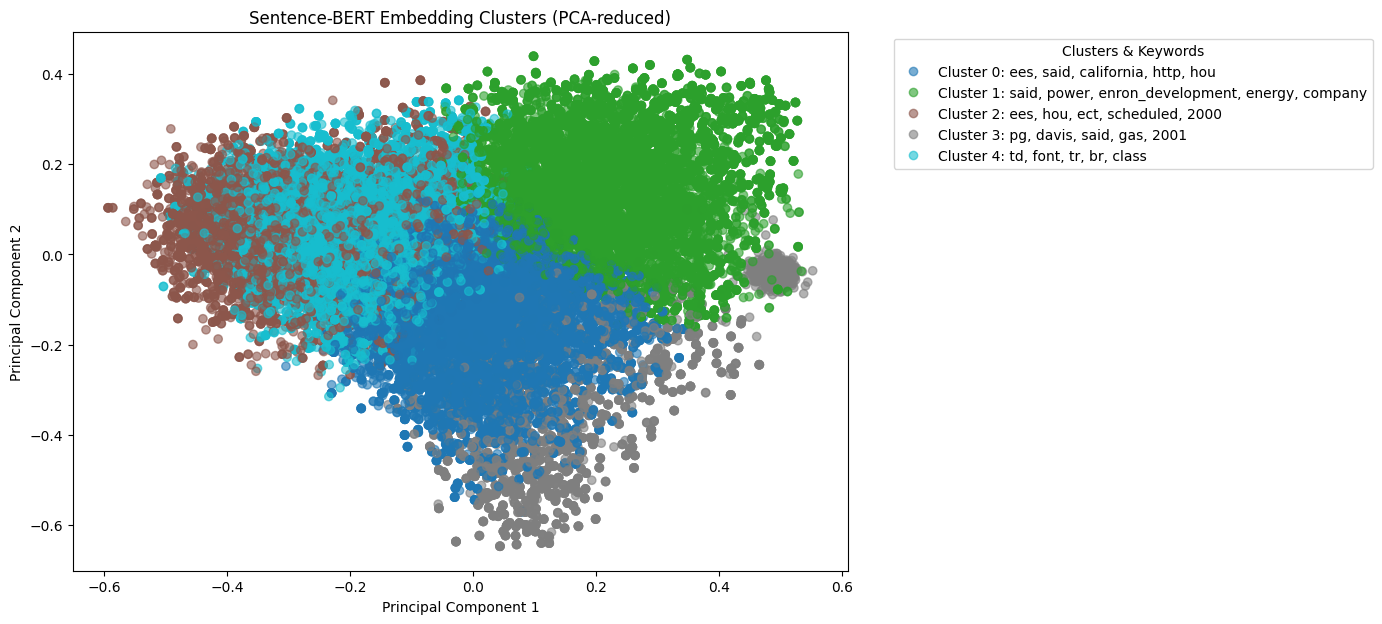

In [ ]:
# -----------------------------
# 5. Visualization of Sentence-BERT Clusters
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce embeddings to 2D for plotting
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10,7))
scatter = plt.scatter(
    reduced_embeddings[:,0],
    reduced_embeddings[:,1],
    c=df_clean['cluster'],
    cmap='tab10',
    alpha=0.6
)

# Add legend with cluster keywords
handles, labels = scatter.legend_elements(prop="colors")
legend_labels = [f"Cluster {i}: {cluster_keywords[i]}" for i in range(num_clusters)]
plt.legend(handles, legend_labels, title="Clusters & Keywords", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Sentence-BERT Embedding Clusters (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


**Filter Important and Urgent emails**


Total Important Emails: 21457
Total Urgent Emails: 11194


/tmp/ipython-input-53918546.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='importance_label', data=df_clean, palette='Set2')


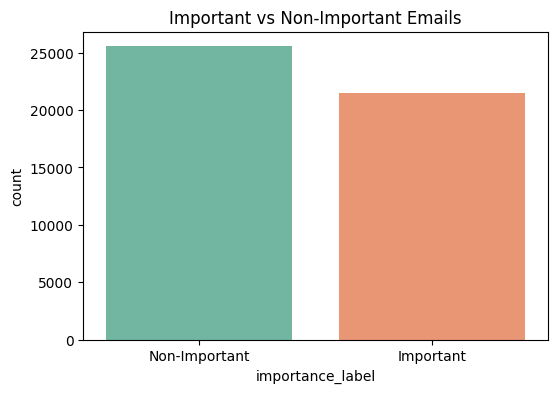

/tmp/ipython-input-53918546.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='urgent', data=df_clean, palette='Set1')


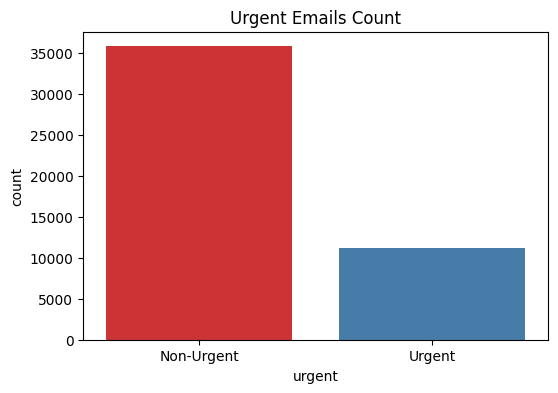

In [ ]:
# Filter Important and Urgent emails
important_emails = df_clean[df_clean['importance_label'] == 'Important']
urgent_emails = df_clean[df_clean['urgent'] == 1]

print(f"Total Important Emails: {len(important_emails)}")
print(f"Total Urgent Emails: {len(urgent_emails)}")

# Plot distribution of Important vs Urgent
plt.figure(figsize=(6,4))
sns.countplot(x='importance_label', data=df_clean, palette='Set2')
plt.title("Important vs Non-Important Emails")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='urgent', data=df_clean, palette='Set1')
plt.title("Urgent Emails Count")
plt.xticks([0,1], ['Non-Urgent','Urgent'])
plt.show()


In [ ]:
# Create a digest dictionary
digest = {}

for cluster in sorted(df_clean['cluster'].unique()):
    cluster_emails = df_clean[df_clean['cluster'] == cluster]['clean_body'].tolist()
    digest[f"Topic {cluster} ({df_clean[df_clean['cluster']==cluster]['topic_name'].iloc[0]})"] = cluster_emails[:5]  # Top 5 emails

# Print the digest
for topic, emails in digest.items():
    print(f"=== {topic} ===")
    for i, email in enumerate(emails, 1):
        print(f"{i}. {email[:200]}...")  # print first 200 chars for readability
    print()


=== Topic 0 (ees, said, california, http, hou) ===
1. What is the structured derivatives portfolio and what is in it?
----Original Message-----
   >
   >
   >Cc:          John Sherriff/LON/ECT@ECT
   >Bcc:      
   >Subj:      UK P/L
   >
   >
   >Greg,
...
2. I do think that more of the trades will ultimately have to be changed, but no 
one else has said anything yet.
----Original Message-----
   >
   >
Earnest/HOU/ECT@ECT
   >Cc:          Derek Bailey/Cor...
3. don't know about the relationship with dave,  you'll have to work on that one.
i will talk to stan, but i can't believe he has any interest in developing 
power plants anywhere.
Portland General did j...
4. you should look into this.  not that there are necessarily violations, but 
there have to at least be questions.  i used to get a curve report that 
showed curve graphs on a volume bar chart.  have yo...
5. this announcement has not gone out for that reason.  we have had a number of 
discussions about it since this was draf

   Topic                                       Topic Name  Total Emails  \
0      0                 ees, said, california, http, hou         12542   
1      1  said, power, enron_development, energy, company         12786   
2      2                   ees, hou, ect, scheduled, 2000          7090   
3      3                       pg, davis, said, gas, 2001          4090   
4      4                          td, font, tr, br, class         10500   

   Unimportant Emails  
0                5992  
1                6558  
2                3755  
3                1225  
4                8018  


/tmp/ipython-input-4145584171.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Topic', y='Unimportant Emails', data=topic_summary_df, palette='coolwarm')


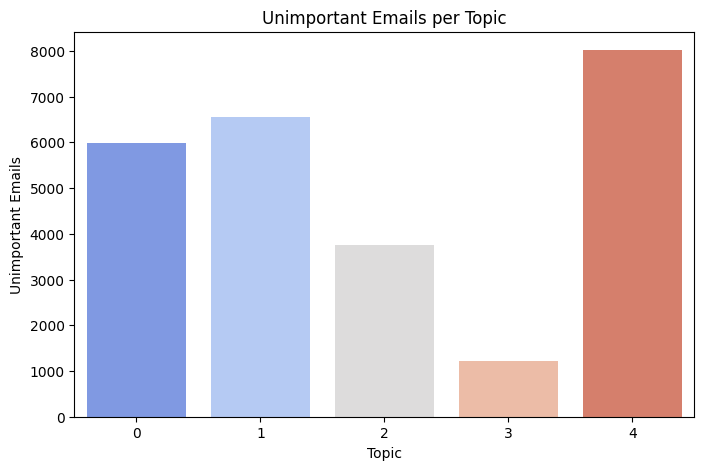

In [ ]:
topic_summary = []

for cluster in sorted(df_clean['cluster'].unique()):
    total_emails = len(df_clean[df_clean['cluster']==cluster])
    unimportant_emails = len(df_clean[(df_clean['cluster']==cluster) & (df_clean['importance_label']=='Non-Important')])
    topic_summary.append({
        'Topic': cluster,
        'Topic Name': df_clean[df_clean['cluster']==cluster]['topic_name'].iloc[0],
        'Total Emails': total_emails,
        'Unimportant Emails': unimportant_emails
    })

topic_summary_df = pd.DataFrame(topic_summary)
print(topic_summary_df)

# Plot Unimportant Emails per Topic
plt.figure(figsize=(8,5))
sns.barplot(x='Topic', y='Unimportant Emails', data=topic_summary_df, palette='coolwarm')
plt.title("Unimportant Emails per Topic")
plt.show()


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

# Download standard punkt
nltk.download('punkt')

# Define summarization
def summarize_email(email_text, num_sentences=3):
    try:
        sentences = sent_tokenize(email_text)  # use standard punkt
        summary = " ".join(sentences[:num_sentences])
    except LookupError:
        # fallback in case punkt_tab is still requested
        nltk.download('punkt_tab') # Download punkt_tab
        sentences = sent_tokenize(email_text)
        summary = " ".join(sentences[:num_sentences])
    return summary

# Apply summarization
df_clean['summary'] = df_clean['clean_body'].apply(lambda x: summarize_email(x, num_sentences=3))

# Check
print(df_clean[['clean_body','summary']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                          clean_body  \
0  Cc:\tMelendrez, Jesus\n <<6-28-01.doc>>  <<SUM...   
1  Cc:\tMelendrez, Jesus\n <<7-26-01.doc>>  <<SUM...   
2  Cc:\tMelendrez, Jesus\nDebbie:\nWould you plea...   
3  <<6-14-01.doc>>  <<SUMMARY.xls>>\nDonna M. Cag...   
4  Cc:\tMelendrez, Jesus\n <<6-6-01.doc>>  <<SUMM...   

                                             summary  
0  Cc:\tMelendrez, Jesus\n <<6-28-01.doc>>  <<SUM...  
1  Cc:\tMelendrez, Jesus\n <<7-26-01.doc>>  <<SUM...  
2  Cc:\tMelendrez, Jesus\nDebbie:\nWould you plea...  
3  <<6-14-01.doc>>  <<SUMMARY.xls>>\nDonna M. Cag...  
4  Cc:\tMelendrez, Jesus\n <<6-6-01.doc>>  <<SUMM...  


In [ ]:
!pip install rouge-score

from rouge_score import rouge_scorer

# Example: Compare generated summaries with manual reference (if available)
# For now, we’ll simulate manual reference summaries for first 5 emails
reference_summaries = [
    "Project submission due by Friday. Team meeting tomorrow. Important report attached.",
    "Client requested updates on the database. Need feedback by next week.",
    "Trading schedule confirmed. Gas shipment details included.",
    "Reminder: submit your weekly report. Team meeting at 10 AM.",
    "Update on the Access database usage and pending tasks."
]

scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
for i in range(5):
    scores = scorer.score(reference_summaries[i], df_clean['summary'].iloc[i])
    print(f"Email {i+1} ROUGE scores:", scores)


Email 1 ROUGE scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
Email 2 ROUGE scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
Email 3 ROUGE scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
Email 4 ROUGE scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
Email 5 ROUGE scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}


**Priority Score Calculation**


In [ ]:
# Priority Score Calculation
df_clean['priority_score'] = 0
df_clean.loc[df_clean['importance_label']=='Important', 'priority_score'] += 2
df_clean.loc[df_clean['urgent']==1, 'priority_score'] += 2

# Optional: add cluster weight based on number of important emails
cluster_weights = df_clean.groupby('cluster')['importance'].sum().to_dict()
df_clean['priority_score'] += df_clean['cluster'].map(cluster_weights)/10  # normalize

# Top 10 priority emails
top_priority = df_clean.sort_values('priority_score', ascending=False)[['summary','importance_label','urgent','priority_score']]
print(top_priority.head(10))


                                                 summary importance_label  \
39000  Customer Support Group is committed to continu...        Important   
36587  Attached are the presentations from the Govern...        Important   
7038   Anne, Ken will be out of town. Rosie\nAnne Cul...        Important   
15441  ----- Forwarded by Steven J Kean/NA/Enron on 0...        Important   
15445  Fortunately, some of us don't need 50 years to...        Important   
46055  If you cannot read today's e-Journal, please v...        Important   
22302  Fortunately, some of us don't need 50 years to...        Important   
15474  Steve:  I intend to get the following email to...        Important   
36615  Bonnie:  Please forward to Michael Kirby. I th...        Important   
13496  Attached is the op-ed by Ken Lay we've submitt...        Important   

       urgent  priority_score  
39000       1           805.8  
36587       1           805.8  
7038        1           805.8  
15441       1           

**Final Digest Creation**


In [ ]:
# Final Digest Creation
final_digest = {}

for cluster in sorted(df_clean['cluster'].unique()):
    cluster_df = df_clean[df_clean['cluster']==cluster].sort_values('priority_score', ascending=False)
    final_digest[f"Topic {cluster} ({df_clean[df_clean['cluster']==cluster]['topic_name'].iloc[0]})"] = cluster_df['summary'].tolist()[:5]

# Print digest with summaries
for topic, summaries in final_digest.items():
    print(f"=== {topic} ===")
    for i, summary in enumerate(summaries, 1):
        print(f"{i}. {summary}")
    print()


=== Topic 0 (ees, said, california, http, hou) ===
1. Tammie:
TX Gas Orig:
	Brian Redmond - MD
	Gary Bryan - Director
	Morris LaRubbio - Manager
	Jennifer Shipos - Manager
	JD Buss (Assoc) is in the Research/Fundamentals Group and is dedicated to TX Gas on a dotted-line relationship. Laura, can you put this in the correct format and submit to Tammie. Thanks,
Brian
Cc:	Lavorato, John; Schoppe, Tammie
Organisational Charts have been requested by one of the potential Buyers.
2. this announcement has not gone out for that reason. we have had a number of 
discussions about it since this was drafted and there seems to be some 
concern about it being inside one of the business units since it is supposed 
to handle investments across the company and would be bringing the EBS assets 
with it. your suggestion that it might report to andy has some merit, but 
there may be other options.
3. I still get 7-8 people every day whining about the "trading vs marketing thing". Some of it is ridiculous bu

/tmp/ipython-input-3022800712.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='Count', data=topic_counts, palette='viridis')


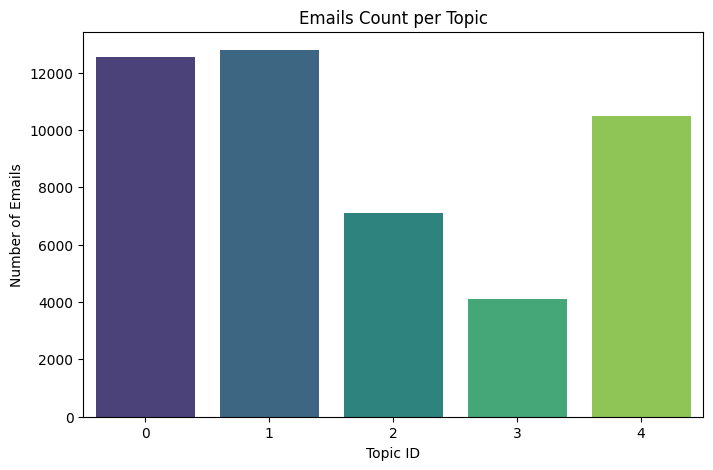

In [ ]:
# Count of emails per topic
topic_counts = df_clean.groupby('cluster')['clean_body'].count().reset_index().rename(columns={'clean_body':'Count'})

plt.figure(figsize=(8,5))
sns.barplot(x='cluster', y='Count', data=topic_counts, palette='viridis')
plt.title("Emails Count per Topic")
plt.xlabel("Topic ID")
plt.ylabel("Number of Emails")
plt.show()
